In [1]:
!pip install ultralytics
!pip install nvidia-smi

In [1]:
!pip install matplotlib pillow numpy


In [8]:
import ultralytics
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib import rc
from PIL import Image
import xml.etree.ElementTree as ET
import os
from os import listdir
import pandas as pd
from sklearn.model_selection import train_test_split
import time
from pathlib import Path
from tqdm import tqdm
import numpy as np
import json
import urllib
import cv2
import torch
import torchvision
from IPython.display import display
import seaborn as sns
from pylab import rcParams


In [9]:
def annotated_image(name, show): 
    image_path = f"signature_data/images/{name}.jpg"  #if working on colab, make sure to find the correct path
    xml_path = f"signature_data/annotations/{name}.xml"
    
    image = Image.open(image_path)
    original_width, original_height = image.size
    
    tree = ET.parse(xml_path)
    root = tree.getroot()
    fig, ax = plt.subplots(1, figsize=(15, 15))
    ax.imshow(image)

    boxes = [] #extracted bounding boxes
    for obj in root.findall(".//object"):
        xmin = int(obj.find(".//bndbox/xmin").text)
        xmax = int(obj.find(".//bndbox/xmax").text)
        ymin = int(obj.find(".//bndbox/ymin").text)
        ymax = int(obj.find(".//bndbox/ymax").text)

        boxes.append([xmin,xmax,ymin,ymax])
        rect = patches.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin, linewidth=.75, edgecolor='r', facecolor='none')
        
        ax.add_patch(rect)
    if show == 1:
        plt.show() #there for line below, uncomment to see result
        print(original_width, original_height)
    plt.close(fig) #adding will allow image to close after viewing
    return boxes


#plt.show()

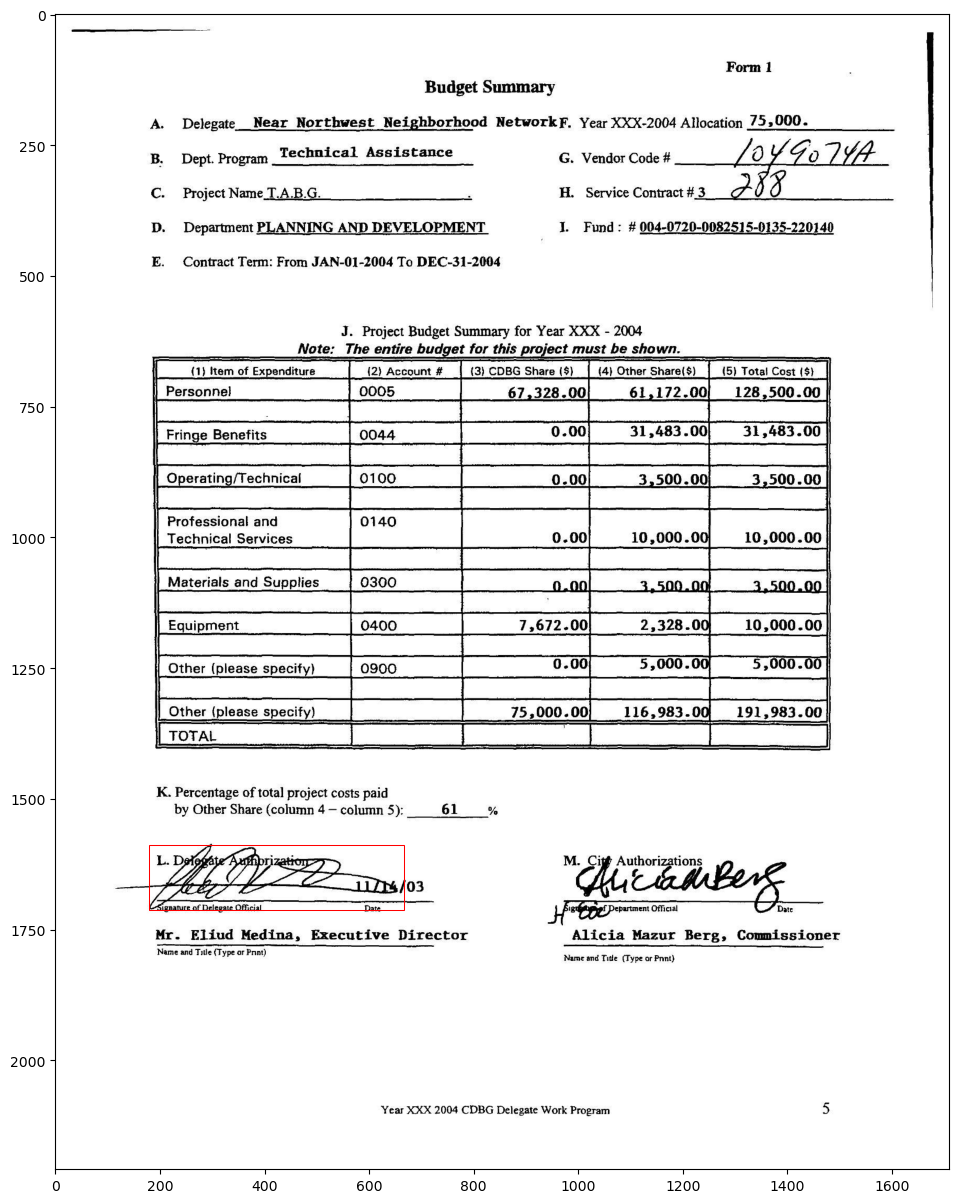

1709 2209


[[178, 667, 1589, 1713]]

In [10]:
annotated_image("chicago_109.pdf_33", 1)

In [5]:
folder_dir = "signature_data/"
image_names = []
b_boxes = {}
for filename in os.listdir(os.path.join(folder_dir, 'images')): #in case of using a different directory. 
    if filename.endswith('.jpg'):
        image_name, _ = os.path.splitext(filename)  # Removes .jpg
        image_names.append(image_name)
image_names[:10]   #stores names     

['chicago_108.pdf_2',
 'chicago_108.pdf_4',
 'chicago_109.pdf_2',
 'chicago_109.pdf_33',
 'chicago_109.pdf_41',
 'chicago_109.pdf_46',
 'chicago_109.pdf_48',
 'chicago_109.pdf_49',
 'chicago_109.pdf_50',
 'chicago_118.pdf_2']

In [11]:
for name in image_names:  #append those anntated bounding boxes into the images 
    b_boxes[name] = annotated_image(name, 0)

In [12]:
os.makedirs("signature_data/labels/", exist_ok=True)
label_paths = [] 
yolo_boxes = {}

In [13]:
def normalize_bboxes(boxes, width, height):
    normalized_boxes = []
    for box in boxes:
        xmin, xmax, ymin, ymax = box
        x_center = ((xmin + xmax) / 2) / width
        y_center = ((ymin + ymax) / 2) / height
        new_width = (xmax - xmin) / width
        new_height = (ymax - ymin) / height
        normalized_boxes.append([0, x_center, y_center, new_width, new_height])  
    return normalized_boxes

In [19]:
for name,boxes in b_boxes.items():
    path = f"signature_data/images/{name}.jpg"
    image = Image.open(path)
    width, height = image.size

    # Normalize the bounding boxes for this image
    new_boxes = normalize_bboxes(boxes, width, height)
    yolo_boxes[name] = new_boxes
    label_paths.append(os.path.join("signature_data/labels/", f"{name}.txt"))
yolo_boxes

{'chicago_108.pdf_2': [[0,
   0.19537199765670768,
   0.6427272727272727,
   0.2032806092560047,
   0.046363636363636364],
  [0, 0.6988869361452841, 0.7765909090909091, 0.29291154071470415, 0.045],
  [0,
   0.23491505565319273,
   0.8288636363636364,
   0.3468072642062097,
   0.06318181818181819],
  [0, 0.6839484475688342, 0.84, 0.37785588752196836, 0.07454545454545454],
  [0,
   0.27973052138254245,
   0.8831818181818182,
   0.3309900410076157,
   0.09272727272727273],
  [0,
   0.7284710017574693,
   0.8906818181818181,
   0.30755711775043937,
   0.08227272727272728]],
 'chicago_108.pdf_4': [[0,
   0.3028705330990041,
   0.4793181818181818,
   0.19214997070884593,
   0.10863636363636364],
  [0,
   0.29115407147041594,
   0.7315909090909091,
   0.43936731107205623,
   0.06136363636363636]],
 'chicago_109.pdf_2': [[0,
   0.7750724637681159,
   0.07950450450450451,
   0.09623188405797102,
   0.03018018018018018]],
 'chicago_109.pdf_33': [[0,
   0.24722059684025746,
   0.7473970122227253,

#### Run line below once!

In [41]:
for label_path, boxes in zip(label_paths, yolo_boxes.values()):
    with open(label_path, 'w') as f:
        for bbox in boxes:
                class_id, x_center, y_center, bbox_width, bbox_height = bbox
                f.write(f"{class_id} {x_center: .6f} {y_center: .6f} {bbox_width:.6f} {bbox_height:.6f}\n") #formats it in a proper way

In [16]:
df = pd.DataFrame({
    'image_name': list(b_boxes.keys()),
    'yolo_format': list(yolo_boxes.values())
})
df['total_bboxes'] = df['yolo_format'].apply(len)  # Total bounding boxes per image
df.head()

,image_name,yolo_format,total_bboxes
0,chicago_108.pdf_2,"[[0, 0.19537199765670768, 0.6427272727272727, ...",6
1,chicago_108.pdf_4,"[[0, 0.3028705330990041, 0.4793181818181818, 0...",2
2,chicago_109.pdf_2,"[[0, 0.7750724637681159, 0.07950450450450451, ...",1
3,chicago_109.pdf_33,"[[0, 0.24722059684025746, 0.7473970122227253, ...",1
4,chicago_109.pdf_41,"[[0, 0.3991150442477876, 0.7534090909090909, 0...",1


In [17]:
import shutil

In [18]:
train, val = train_test_split(image_names, test_size=0.15, random_state=45)

#### Read before running block below:

- Currently folder structure looks like: \
C: \
├───annotations \
├───images \
├───labels 
-  new directory will create new data_set with test/train arranged based on line above \
C: \
├───annotations \
├───images \
├───labels \
├───test_set \
│   ....├───images \
│   ....└───labels \
└───train_set \
    .........├───images \
    .........└───labels 

##### still keep the raw images/annotations AND Labels if you want to change change split size


In [74]:
path_for_dataset = input("Enter current path (google colab for full: " )
%cd path_for_dataset

Enter current path (google colab for full:  C:\Users\pgarl\OneDrive\Desktop\Signature_data\


[WinError 2] The system cannot find the file specified: 'path_for_dataset'
C:\Users\pgarl\OneDrive\Desktop\Signature_data


In [69]:
data_set = "signature_data/"

train_set = os.path.join(data_set, "train_set")
test_set = os.path.join(data_set,"test_set")
os.makedirs(train_set, exist_ok=True)
os.makedirs(test_set, exist_ok=True)

# Initialize paths for train and test set with respective images/labels
train_set_images = os.path.join(train_set, "images")
test_set_images = os.path.join(test_set, "images")
train_set_labels = os.path.join(train_set, "labels")
test_set_labels = os.path.join(test_set, "labels")

# Keep track of original paths
og_image_path = "signature_data/images"
og_label_path = "signature_data/labels"

# Function to copy images to new structure
def copy_images(dataset, original_path, data_images):
    for img_name in dataset:
        img_file = f"{img_name}.jpg"
        src_path = os.path.join(original_path, img_file)
        dst_path = os.path.join(data_images, img_file)
        shutil.copy(src_path, dst_path)  # Copy the image file

# Function to move labels to new structure
def move_labels(dataset, original_label_path, data_labels):
    for img_name in dataset:
        label_file = f"{img_name}.txt"
        src_path = os.path.join(original_label_path, label_file)
        dst_path = os.path.join(data_labels, label_file)
        shutil.move(src_path, dst_path)  # Move the label file
%cd C:\Users\pgarl\OneDrive\Desktop\Signature_data

C:\Users\pgarl\OneDrive\Desktop\Signature_data


In [75]:
choice = input("Run lines below for first time (y/n): ")
if choice.lower() == "y":
    # Call functions with lists of image names and appropriate directories

    os.makedirs(train_set_images, exist_ok=True)
    os.makedirs(test_set_images, exist_ok=True)
    os.makedirs(train_set_labels, exist_ok=True)
    os.makedirs(test_set_labels, exist_ok=True)

    copy_images(train, og_image_path, train_set_images)
    copy_images(val, og_image_path, test_set_images)
    move_labels(train, og_label_path, train_set_labels)
    move_labels(val, og_label_path, test_set_labels)
else:
    print("Operation cancelled.")
    

Run lines below for first time (y/n):  n


Operation cancelled.


#### Optional 
- Below starts the training stage
- make sure to clone the correct yolov5 repo, cd into repo, then install dependencies (pip install -r reqirements.txt)
- then run lines below --> make sure to change yolo_path to desired project repo

In [38]:
yolo_path = input("Add full path (starting from C:")

Add full path (starting from C: C:\Users\pgarl\OneDrive\Desktop\Signature_data\


In [39]:
os.chdir(os.path.join(yolo_path, "yolov5"))
print(os.getcwd())

C:\Users\pgarl\OneDrive\Desktop\Signature_data\yolov5


In [27]:
!pip install -r requirements.txt

#makes sure that you are on the updated verison of the code

In [23]:
!pip install --upgrade setuptools

#### Next Stages
- create a configuration file to specify test and train datasets, classes, and names of classes
- choose the model and weights you want to consider in the cloned folder --> make sure to change the no of classes to the project specified  (in this case : 1)
- ensure that there is a Segmentation function in your train.py / any conflicts with dependencies (!pip check) 